# heart_disease.py converted to notebook
This notebook mirrors the original `heart_disease.py` script: it loads the training and test CSVs, prints a sample of `test` IDs and basic information from `train`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# load the data
test_ids = test['id']

# save the id column
print(test_ids.head(20))
print(f"\nNumber of rows in test_ids: {len(test_ids)}")

print("\nTraining Data:")
print(train.head())
# Display the first few rows of the training data

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
#how many colums in train data
print(f"\nNumber of columns in training data: {train.shape[1]}")


Number of columns in training data: 15


In [ ]:
How many features are there in the training data?
print(f"\nNumber of features in training data: {train.shape[1] - 1}")  # Subtracting 1 for the target column

Object `data` not found.

Number of features in training data: 14


In [ ]:
#cAN You list colummns description vertically
for col in train.columns:
    print(col)

id
Age
Sex
Chest pain type
BP
Cholesterol
FBS over 120
EKG results
Max HR
Exercise angina
ST depression
Slope of ST
Number of vessels fluro
Thallium
Heart Disease


Cleaning  Train Data

In [ ]:
train.columns = (
    train.columns
    .str.lower()
    .str.replace(" ", "_")
)

Separate  Features  and Target


In [ ]:
#Drop Heart disease from train set and create a new dataset x
x = train.drop("heart_disease", axis=1)
y = train["heart_disease"]


In [ ]:
#Cean  Data set X and Y
x = x.dropna()
y = y.dropna()

In [ ]:
#Quick Sanity check of X and Y
print(f"\nShape of X: {x.shape}")
print(f"Shape of Y: {y.shape}")
#count of Y values


Shape of X: (630000, 14)
Shape of Y: (630000,)


In [ ]:
#Add Feature Engineering here

# Example: Create a new feature by combining existing features

In [ ]:
#Clean test data columns
test.columns = (
    test.columns
    .str.lower()
    .str.replace(" ", "_")
)

In [ ]:
#can you list column vertically for test data
for col in test.columns:
    print(col)

id
Age
Sex
Chest pain type
BP
Cholesterol
FBS over 120
EKG results
Max HR
Exercise angina
ST depression
Slope of ST
Number of vessels fluro
Thallium


In [ ]:
for df in [x, test]:

    # High blood pressure
    df["high_bp"] = (df["bp"] >= 140).astype(int)

    # High cholesterol
    df["high_cholesterol"] = (df["cholesterol"] >= 240).astype(int)

    # High fasting blood sugar
    df["high_fbs"] = (df["fbs_over_120"] == 1).astype(int)

    # Exercise induced angina
    df["exercise_angina_flag"] = (df["exercise_angina"] == 1).astype(int)

#Severity Tab

In [ ]:
for df in [x, test]:

    # Age risk group
    df["age_group"] = pd.cut(
        df["age"],
        bins=[0, 40, 55, 70, 120],
        labels=[0, 1, 2, 3]
    )

    # ST depression severity
    df["st_severity"] = pd.cut(
        df["st_depression"],
        bins=[-1, 1, 2, 10],
        labels=[0, 1, 2]
    )

    # Max heart rate risk
    df["hr_risk"] = pd.cut(
        df["max_hr"],
        bins=[0, 100, 140, 220],
        labels=[2, 1, 0]   # lower HR = higher risk
    )


In [ ]:
# Interaction Features
for df in [x, test]:

    # BP + cholesterol combined risk
    df["bp_chol_risk"] = df["high_bp"] * df["high_cholesterol"]

    # Age + exercise angina interaction
    df["age_exercise_risk"] = df["age"] * df["exercise_angina"]

    # ST depression weighted by vessels
    df["st_vessel_risk"] = df["st_depression"] * df["number_of_vessels_fluro"]


In [ ]:
#Heart Strees Indicators
for df in [x, test]:

    # Predicted max heart rate
    df["predicted_hr"] = 220 - df["age"]

    # Heart rate reserve
    df["hr_reserve"] = df["max_hr"] - df["predicted_hr"]

In [ ]:
#Encode Categorical Features
categorical_cols = [
    "sex",
    "chest_pain_type",
    "ekg_results",
    "slope_of_st",
    "thallium",
    "age_group",
    "st_severity",
    "hr_risk"
]


In [ ]:
full = pd.concat([x, test], axis=0)

full = pd.get_dummies(
    full,
    columns=categorical_cols,
    drop_first=True
)

x = full.iloc[:len(x)]
test = full.iloc[len(x):]

In [ ]:
print(x.shape)
print(x.isnull().sum().sum())


(630000, 35)
0


In [ ]:
#Encode target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Target encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Target encoding: {'Absence': np.int64(0), 'Presence': np.int64(1)}


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# x = engineered features
# y_encoded = target (numeric)

x_train, x_val, y_train, y_val = train_test_split(
    x,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

model.fit(x_train, y_train)

val_pred = model.predict(x_val)
val_prob = model.predict_proba(x_val)[:, 1]

print("Accuracy:", accuracy_score(y_val, val_pred))
print("ROC-AUC:", roc_auc_score(y_val, val_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, val_pred))
print("\nClassification Report:\n", classification_report(y_val, val_pred))

Accuracy: 0.8890873015873015
ROC-AUC: 0.9557107316656711

Confusion Matrix:
 [[63042  6467]
 [ 7508 48983]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90     69509
           1       0.88      0.87      0.88     56491

    accuracy                           0.89    126000
   macro avg       0.89      0.89      0.89    126000
weighted avg       0.89      0.89      0.89    126000



Improve recall (medical priority)

In [ ]:
#Current Recall Base Line
from sklearn.metrics import classification_report

print(classification_report(y_val, val_pred))
# Class 0 = Absence (no heart disease)
# Class 1 = Presence (heart disease detected)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     69509
           1       0.88      0.87      0.88     56491

    accuracy                           0.89    126000
   macro avg       0.89      0.89      0.89    126000
weighted avg       0.89      0.89      0.89    126000



In [ ]:
#lower Theshold to increase Recall for class 
#lower Theshold to increase Recall for class 1
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

threshold = 0.35

val_pred_recall = (val_prob >= threshold).astype(int)

print(confusion_matrix(y_val, val_pred_recall))
print(classification_report(y_val, val_pred_recall))


[[59798  9711]
 [ 4995 51496]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     69509
           1       0.84      0.91      0.88     56491

    accuracy                           0.88    126000
   macro avg       0.88      0.89      0.88    126000
weighted avg       0.89      0.88      0.88    126000



#Penalize False Negatives

In [ ]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
print(scale_pos_weight)


1.230453658342295


In [ ]:
#Retrain Model
model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

model.fit(x_train, y_train)

val_prob = model.predict_proba(x_val)[:, 1]
val_pred_weighted = (val_prob >= 0.35).astype(int)

print(classification_report(y_val, val_pred_weighted))


              precision    recall  f1-score   support

           0       0.93      0.84      0.88     69509
           1       0.82      0.92      0.87     56491

    accuracy                           0.88    126000
   macro avg       0.88      0.88      0.88    126000
weighted avg       0.88      0.88      0.88    126000



In [ ]:
#Improbve Recall
from sklearn.metrics import recall_score

recalls = []

for t in np.arange(0.2, 0.6, 0.05):
    preds = (val_prob >= t).astype(int)
    recalls.append((t, recall_score(y_val, preds)))

for r in recalls:
    print(f"Threshold {r[0]:.2f} → Recall {r[1]:.3f}")


Threshold 0.20 → Recall 0.958
Threshold 0.25 → Recall 0.947
Threshold 0.30 → Recall 0.935
Threshold 0.35 → Recall 0.923
Threshold 0.40 → Recall 0.911
Threshold 0.45 → Recall 0.898
Threshold 0.50 → Recall 0.883
Threshold 0.55 → Recall 0.868


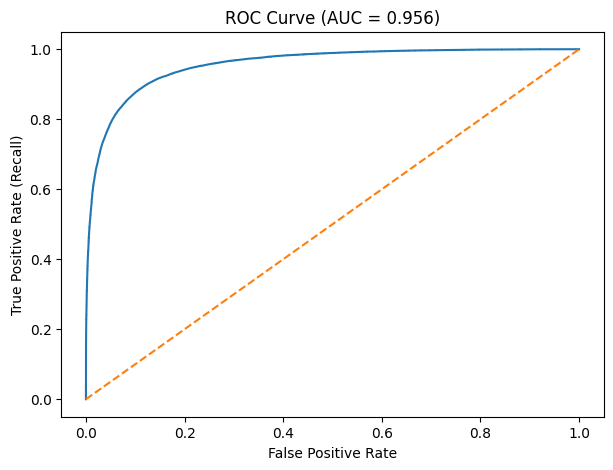

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_val, val_prob)
auc = roc_auc_score(y_val, val_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC Curve (AUC = {auc:.3f})")
plt.show()


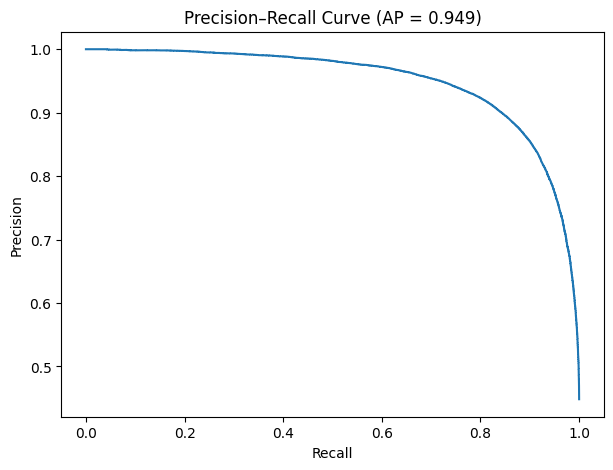

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_val, val_prob)
ap = average_precision_score(y_val, val_prob)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.show()


In [ ]:
#Create SHAP xboost model explainability
import shap
import pandas as pd
import numpy as np

# Convert data to numeric (ensure all dtypes are float)
x_val_numeric = x_val.astype(np.float32)
x_train_numeric = x_train.astype(np.float32)

# Important: SHAP needs a sample background for speed
background = x_train_numeric.sample(min(100, len(x_train_numeric)), random_state=42)

explainer = shap.TreeExplainer(model, data=background)
shap_values = explainer.shap_values(x_val_numeric)

print("SHAP explainer created successfully!")

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'